In [272]:
!wget -P ./data/ https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/data/budget.csv
!wget -P ./data/ https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/data/cost.csv
!wget -P ./data/ https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/data/participation.csv

--2025-08-06 17:33:51--  https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/data/budget.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179 [text/plain]
Saving to: ‘./data/budget.csv.2’

budget.csv.2        100%[===================>]     179  --.-KB/s    in 0s      

2025-08-06 17:33:52 (17.3 MB/s) - ‘./data/budget.csv.2’ saved [179/179]

--2025-08-06 17:33:52--  https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/data/cost.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157

In [286]:
from typing import Literal
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd


def plot_budget(
    df: pd.DataFrame,
    priority_type: Literal["budget", "start", "duration"],
    priority_ascending: bool,
    ax: plt.Axes = None,
    plot_today: bool = True,
):
    now = datetime.now()
    edges = sorted(set(df["start"]).union(set(df["end"])))
    values = {name: [0] * len(edges) for name in df["name"]}

    for i, edge in enumerate(edges):
        active_records = df[(df["start"] <= edge) & (df["end"] > edge)]
        for _, record in active_records.iterrows():
            values[record["name"]][i] = record["budget"]

    x = np.array(edges, dtype="datetime64")
    priority = df.sort_values(by=priority_type, ascending=priority_ascending)[
        "name"
    ].tolist()
    y_priority = np.vstack([values[name] for name in priority])
    if not ax:
        _, ax = plt.subplots(figsize=(8, 4))
    ax.stackplot(x, y_priority, labels=priority, baseline="zero", step="post")
    if plot_today:
        ax.axvline(
            x=now,
            color="black",
            label=f"today ({now.strftime('%Y-%m-%d')})",
            linestyle="dashed",
        )

    ax.legend()
    return ax


def plot_budget_cumsum(df: pd.DataFrame, ax: plt.Axes = None, plot_today: bool = True):
    start_budget_map = df.groupby("start")["budget"].sum().to_dict()
    end_budget_map = df.groupby("end")["budget"].sum().to_dict()
    edges = sorted(set(df["start"]).union(set(df["end"])))

    values = []
    sum = 0
    for edge in edges:
        if edge in start_budget_map:
            sum += start_budget_map[edge]
        if edge in end_budget_map:
            sum -= end_budget_map[edge]
        values.append(sum)
    values.pop()
    if not ax:
        _, ax = plt.subplots(figsize=(8, 4))
    now = datetime.now()

    ax.stairs(values, edges, label="budget chart", color="tab:blue")
    if plot_today:
        ax.axvline(
            x=now,
            color="black",
            label=f"today ({now.strftime('%Y-%m-%d')})",
            linestyle="dashed",
        )

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=60)
    ax.legend()
    return ax


def plot_staff_cost_cumsum(
    df: pd.DataFrame,
    ax: plt.Axes = None,
    plot_today: bool = True,
    color: str = None,
    label="Total cost chart",
):
    now = datetime.now()

    df["start"] = pd.to_datetime(df["start"])
    df["end"] = pd.to_datetime(df["end"])
    df = df.sort_values(by=["start"])
    df["total-effect"] = df["monthly-rate"] * (df["end"] - df["start"]).dt.days / 30

    start_rate_map = df.groupby("start")["monthly-rate"].sum().to_dict()
    end_rate_map = df.groupby("end")["monthly-rate"].sum().to_dict()
    end_drop_map = df.groupby("end")["total-effect"].sum().to_dict()

    edges = sorted(set(df["start"]).union(set(df["end"])))

    values, timestamps, sum, rate, previous_edge = [], [], 0, 0, edges[0]
    for edge in edges:
        duration = (edge - previous_edge).days / 30
        sum += rate * duration
        values.append(sum)
        timestamps.append(edge)

        if edge in end_rate_map:
            # the amount of sum that decreases when a staff exits from project
            sum -= end_drop_map[edge]
            values.append(sum)
            timestamps.append(edge)
            rate -= end_rate_map[edge]

        if edge in start_rate_map:
            rate += start_rate_map[edge]

        previous_edge = edge

    if not ax:
        fig, ax = plt.subplots()

    ax.plot(timestamps, values, label=label, color=color)
    if plot_today:
        ax.axvline(
            x=now,
            color="black",
            label=f"today ({now.strftime('%Y-%m-%d')})",
            linestyle="dashed",
        )
    plt.xticks(rotation=60)
    ax.legend(loc="upper right")
    return ax


def plot_staff_proportional_cost(
    participation_df: pd.DataFrame,
    cost_df: pd.DataFrame,
    budget_df: pd.DataFrame,
    project_name: str,
    ax: plt.Axes = None,
    plot_today: bool = True,
    color: str = None,
):
    project = budget_df[budget_df["name"] == project_name].iloc[0]
    start, end = project["start"], project["end"]

    active_staffs = cost_df[(cost_df["start"] < end) & (cost_df["end"] > start)].copy()
    active_staffs["start"] = active_staffs["start"].apply(lambda x: max(x, start))
    active_staffs["end"] = active_staffs["end"].apply(lambda x: min(x, end))

    for idx, record in active_staffs.iterrows():
        participation_record = participation_df[
            (participation_df["staff"] == record["staff"])
            & (participation_df["name"] == project_name)
        ]
        if not participation_record.empty:
            rate = participation_record.iloc[0]["participation"]
            active_staffs.at[idx, "monthly-rate"] = record["monthly-rate"] * rate
        else:
            active_staffs.at[idx, "monthly-rate"] = 0

    return plot_staff_cost_cumsum(active_staffs, ax, plot_today, color, label="Proportional cost chart")


In [287]:
def clip_dates(df, start_date, end_date):
    df = df.copy()
    df['start'] = df['start'].apply(lambda x: max(x, pd.to_datetime(start_date)))
    df['end'] = df['end'].apply(lambda x: min(x, pd.to_datetime(end_date)))
    return df

In [288]:
import pandas as pd

budget_df = pd.read_csv('data/budget.csv')

In [289]:
budget_df["start"] = pd.to_datetime(budget_df["start"])
budget_df["end"] = pd.to_datetime(budget_df["end"])
budget_df["duration"] = budget_df["end"] - budget_df["start"]
df = budget_df.sort_values(by=["start"])

In [290]:
budget_df

,name,start,end,budget,duration
0,Kinder,2024-01-01,2025-06-30,20000,546 days
1,TAP,2026-01-01,2028-06-30,30000,911 days
2,web,2025-01-01,2035-10-30,1000,3954 days
3,p2,2024-09-01,2026-10-30,9400,789 days
4,p3,2028-01-01,2029-10-30,9400,668 days


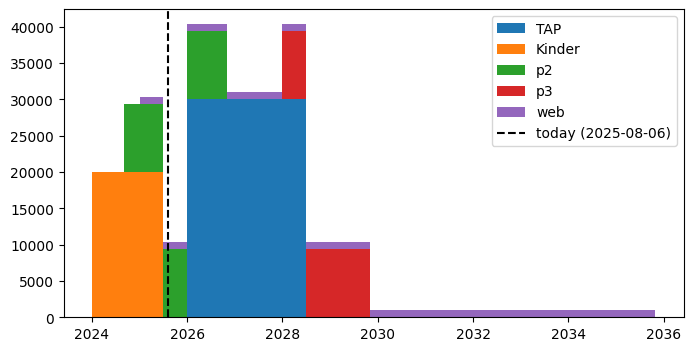

In [291]:
priority_type = "budget"   # choices are budget - start - duration
priority_ascending = False # choices are False - True

ax = plot_budget(budget_df, priority_type, priority_ascending)
plt.show()

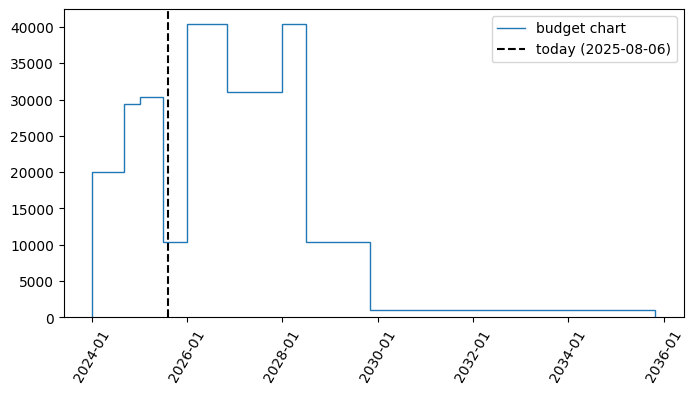

In [292]:
plot_budget_cumsum(df)
plt.show()

In [293]:
import pandas as pd

cost_df = pd.read_csv('data/cost.csv')
cost_df

,staff,monthly-rate,start,end
0,bidar,600,2024-01-01,2026-01-30
1,ali,700,2024-09-01,2025-04-30
2,hassan,200,2026-10-02,2027-09-30
3,hamid,1000,2027-06-02,2028-09-30


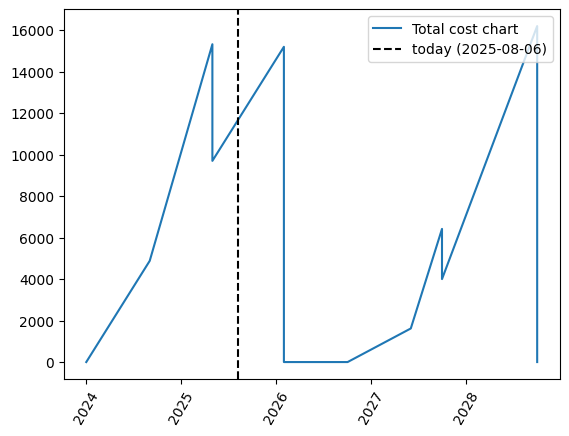

In [294]:
plot_staff_cost_cumsum(cost_df)
plt.show()

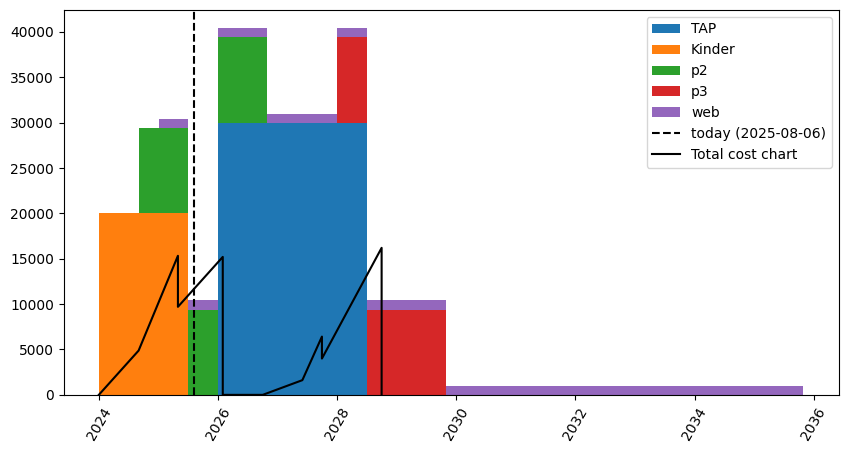

In [295]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_budget(budget_df, priority_type, priority_ascending, ax)
plot_staff_cost_cumsum(cost_df, ax, plot_today=False, color="black")
plt.show()

In [296]:
import pandas as pd

participation_df = pd.read_csv('data/participation.csv')
participation_df

,name,staff,participation
0,Kinder,bidar,0.1
1,Kinder,ali,0.3
2,Kinder,hassan,0.4
3,Web,hamid,0.0
4,TAP,bidar,0.7
5,TAP,ali,0.3
6,TAP,hassan,0.4
7,TAP,hamid,0.9
8,Web,bidar,0.2
9,Web,ali,0.4


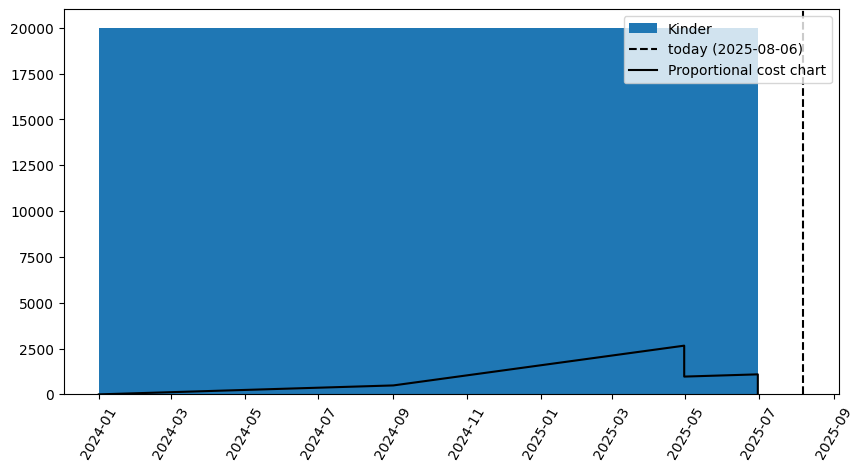

In [297]:
fig, ax = plt.subplots(figsize=(10, 5))

plot_budget(budget_df[budget_df['name']=='Kinder'], priority_type, priority_ascending, ax)
plot_staff_proportional_cost(participation_df, cost_df, budget_df, "Kinder", ax, color='black', plot_today=False)
plt.show()

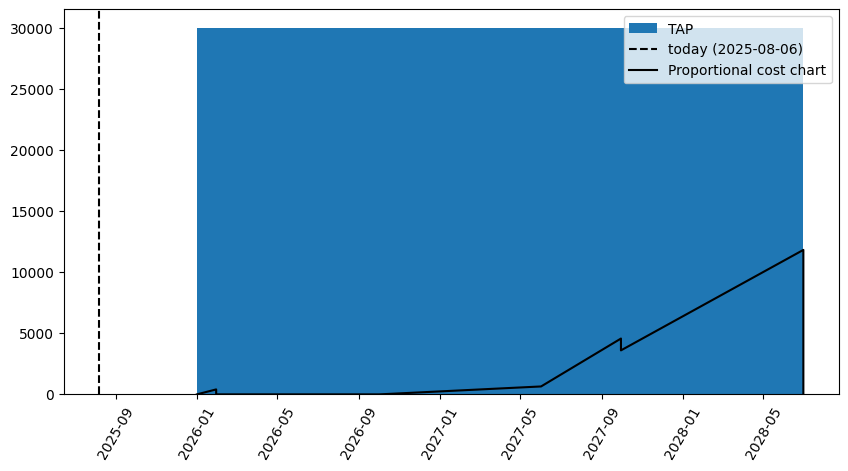

In [298]:
fig, ax = plt.subplots(figsize=(10, 5))

plot_budget(budget_df[budget_df['name']=='TAP'], priority_type, priority_ascending, ax)
plot_staff_proportional_cost(participation_df, cost_df, budget_df, "TAP", ax, color='black', plot_today=False)
plt.show()